### Customer retention Analytics

##### Business Problem:
An International bank collected a sample data of 10,000 customers. They observed that some of their custimers are leaving or churning in an unusually high rate and they want to find understand and access why their customers keep leaving. They have hiered you as a data scientist to look into the data to give then some insight.

##### Data:
The data was collected within the last 5 months, the feautures include the customer's name, creditscore, geography, gendey,age,tenure,balnce, number of products(accounts),credit card status(whether they have one or not), estimated salary, activity status(active member or not) and if the customer remained with them.

#### Goal:
Your goal is to create a geodemographic segmentation  to identify which of the customers have the highest risk of leaving.

In [1]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
torch.__version__

'1.7.1'

### Working on a banking dataset to detect churn activities

In [2]:
#importing the data
data = pd.read_csv("https://raw.githubusercontent.com/AdeloreSimiloluwa/Artificial-Neural-Network/master/data/Churn_Modelling.csv")

In [3]:
#viewing the data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


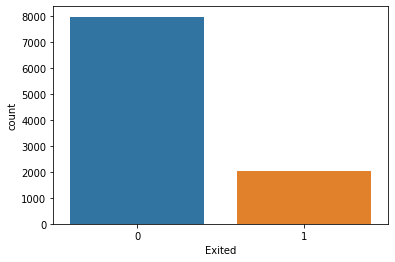

In [4]:
#frequency of the target classes
sns.countplot(x='Exited', data=data)

From the data we have more information on the customers that stayed at the bank

In [5]:
#checking for datatype of each column
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
#checking for missing values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
#dropping some columns that are not needed
data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
#viewing the unique values in Geography column
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
#data features
X = data.iloc[:,:-1]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [10]:
#target data
y = data.iloc[:,-1:]
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [11]:
#encoding the categorical columns
le = LabelEncoder()
ohe = OneHotEncoder()
X['Gender'] = le.fit_transform(X['Gender'])
geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

#getting feature name after onehotencoding
geo_df.columns = ohe.get_feature_names(['Geography'])

#merging geo_df with the main data
X = X.join(geo_df)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,France,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


In [12]:
#dropping the old columns after encoding
X.drop(columns=['Geography'], axis=1, inplace=True)
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


### Split Data

In [13]:
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)

In [14]:
data_dict = {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}
for i in data_dict:
    print("The shape of {} is {}".format(i,data_dict[i].shape))

The shape of X_train is (8000, 12)
The shape of X_test is (2000, 12)
The shape of y_train is (8000, 1)
The shape of y_test is (2000, 1)


### Feature scaling

In [15]:
sc =StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\JADESOLA\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JADESOLA\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JADESOLA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Deep learning model

In [16]:
#setting model hyper-parameters
EPOCHS = 1
BATCH_SIZE =10
LEARNING_RATE = 0.001

In [17]:
X_test.shape

(2000, 12)

#### Defining custom dataset

In [18]:
#train data
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self,index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))

In [19]:
#test data
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self,index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)

test_data = testData(torch.FloatTensor(X_test))

### Defining dataloader to read dataset class in batches

In [20]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=1)

### defining neural network architecture

In [21]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        #number of input features is 12
        self.layer_1 = nn.Linear(12, 16)
        self.layer_2 = nn.Linear(16, 8)
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        
    #feed forward network
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
#initializing optimizer and loss
classifier = binaryClassification()
classifier.to(device)
print(classifier)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
#function to calculate accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    results_sum = (y_pred_tag == y_test).sum().float()
    acc = results_sum/y_test.shape[0]
    acc =torch.round(acc*100)
    return acc

In [25]:
#training the model
classifier.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #setting gradient to 0 per mini-batch
        optimizer.zero_grad()
        y_pred = classifier(X_batch)
        loss =criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:0.00079 | Acc:0.075
Epoch 001: | Loss:0.00175 | Acc:0.125
Epoch 001: | Loss:0.00256 | Acc:0.188
Epoch 001: | Loss:0.00331 | Acc:0.275
Epoch 001: | Loss:0.00426 | Acc:0.338
Epoch 001: | Loss:0.00510 | Acc:0.425
Epoch 001: | Loss:0.00591 | Acc:0.487
Epoch 001: | Loss:0.00671 | Acc:0.562
Epoch 001: | Loss:0.00753 | Acc:0.650
Epoch 001: | Loss:0.00852 | Acc:0.688
Epoch 001: | Loss:0.00933 | Acc:0.750
Epoch 001: | Loss:0.01021 | Acc:0.812
Epoch 001: | Loss:0.01104 | Acc:0.863
Epoch 001: | Loss:0.01188 | Acc:0.950
Epoch 001: | Loss:0.01265 | Acc:1.050
Epoch 001: | Loss:0.01342 | Acc:1.137
Epoch 001: | Loss:0.01420 | Acc:1.238
Epoch 001: | Loss:0.01512 | Acc:1.312
Epoch 001: | Loss:0.01599 | Acc:1.400
Epoch 001: | Loss:0.01697 | Acc:1.450
Epoch 001: | Loss:0.01776 | Acc:1.538
Epoch 001: | Loss:0.01845 | Acc:1.650
Epoch 001: | Loss:0.01928 | Acc:1.725
Epoch 001: | Loss:0.02006 | Acc:1.812
Epoch 001: | Loss:0.02088 | Acc:1.863
Epoch 001: | Loss:0.02176 | Acc:1.950
Epoch 001: |

Epoch 001: | Loss:0.16171 | Acc:19.137
Epoch 001: | Loss:0.16250 | Acc:19.200
Epoch 001: | Loss:0.16329 | Acc:19.275
Epoch 001: | Loss:0.16393 | Acc:19.363
Epoch 001: | Loss:0.16473 | Acc:19.438
Epoch 001: | Loss:0.16539 | Acc:19.538
Epoch 001: | Loss:0.16612 | Acc:19.625
Epoch 001: | Loss:0.16690 | Acc:19.725
Epoch 001: | Loss:0.16754 | Acc:19.825
Epoch 001: | Loss:0.16833 | Acc:19.913
Epoch 001: | Loss:0.16899 | Acc:20.012
Epoch 001: | Loss:0.16965 | Acc:20.100
Epoch 001: | Loss:0.17018 | Acc:20.225
Epoch 001: | Loss:0.17078 | Acc:20.325
Epoch 001: | Loss:0.17138 | Acc:20.425
Epoch 001: | Loss:0.17205 | Acc:20.512
Epoch 001: | Loss:0.17273 | Acc:20.600
Epoch 001: | Loss:0.17352 | Acc:20.688
Epoch 001: | Loss:0.17425 | Acc:20.775
Epoch 001: | Loss:0.17498 | Acc:20.863
Epoch 001: | Loss:0.17555 | Acc:20.975
Epoch 001: | Loss:0.17612 | Acc:21.087
Epoch 001: | Loss:0.17686 | Acc:21.188
Epoch 001: | Loss:0.17757 | Acc:21.275
Epoch 001: | Loss:0.17813 | Acc:21.387
Epoch 001: | Loss:0.17871

Epoch 001: | Loss:0.29309 | Acc:39.825
Epoch 001: | Loss:0.29383 | Acc:39.900
Epoch 001: | Loss:0.29473 | Acc:39.975
Epoch 001: | Loss:0.29518 | Acc:40.087
Epoch 001: | Loss:0.29567 | Acc:40.200
Epoch 001: | Loss:0.29645 | Acc:40.263
Epoch 001: | Loss:0.29704 | Acc:40.362
Epoch 001: | Loss:0.29771 | Acc:40.450
Epoch 001: | Loss:0.29823 | Acc:40.562
Epoch 001: | Loss:0.29872 | Acc:40.663
Epoch 001: | Loss:0.29934 | Acc:40.750
Epoch 001: | Loss:0.30016 | Acc:40.825
Epoch 001: | Loss:0.30055 | Acc:40.950
Epoch 001: | Loss:0.30104 | Acc:41.062
Epoch 001: | Loss:0.30154 | Acc:41.175
Epoch 001: | Loss:0.30198 | Acc:41.288
Epoch 001: | Loss:0.30233 | Acc:41.413
Epoch 001: | Loss:0.30294 | Acc:41.500
Epoch 001: | Loss:0.30338 | Acc:41.612
Epoch 001: | Loss:0.30374 | Acc:41.737
Epoch 001: | Loss:0.30427 | Acc:41.837
Epoch 001: | Loss:0.30486 | Acc:41.938
Epoch 001: | Loss:0.30538 | Acc:42.025
Epoch 001: | Loss:0.30580 | Acc:42.138
Epoch 001: | Loss:0.30662 | Acc:42.225
Epoch 001: | Loss:0.30723

Epoch 001: | Loss:0.41026 | Acc:60.950
Epoch 001: | Loss:0.41099 | Acc:61.025
Epoch 001: | Loss:0.41142 | Acc:61.138
Epoch 001: | Loss:0.41189 | Acc:61.237
Epoch 001: | Loss:0.41231 | Acc:61.350
Epoch 001: | Loss:0.41282 | Acc:61.425
Epoch 001: | Loss:0.41360 | Acc:61.500
Epoch 001: | Loss:0.41410 | Acc:61.600
Epoch 001: | Loss:0.41458 | Acc:61.700
Epoch 001: | Loss:0.41529 | Acc:61.788
Epoch 001: | Loss:0.41578 | Acc:61.888
Epoch 001: | Loss:0.41619 | Acc:62.000
Epoch 001: | Loss:0.41670 | Acc:62.100
Epoch 001: | Loss:0.41719 | Acc:62.200
Epoch 001: | Loss:0.41758 | Acc:62.312
Epoch 001: | Loss:0.41836 | Acc:62.400
Epoch 001: | Loss:0.41939 | Acc:62.450
Epoch 001: | Loss:0.41992 | Acc:62.550
Epoch 001: | Loss:0.42047 | Acc:62.638
Epoch 001: | Loss:0.42129 | Acc:62.712
Epoch 001: | Loss:0.42185 | Acc:62.800
Epoch 001: | Loss:0.42238 | Acc:62.900
Epoch 001: | Loss:0.42279 | Acc:63.013
Epoch 001: | Loss:0.42322 | Acc:63.112
Epoch 001: | Loss:0.42393 | Acc:63.200
Epoch 001: | Loss:0.42434

In [30]:
#test model
y_pred_list = []
classifier.eval()
count = 0
#ensures no back propagation during testing and reduces memeory usage
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = classifier(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [i.squeeze().tolist() for i in y_pred_list] 
    #y_pred_list = [bool(i) for i in y_pred_list]

In [40]:
acc = binary_acc(torch.FloatTensor(y_pred_list), torch.FloatTensor(y_test.values))
accu = acc.item()
print(accu/len(y_test))
print(accu)

76.101
152202.0


In [27]:
df1 = pd.DataFrame(y_test)
df1.reset_index(inplace=True)
df1.drop(columns=['index'], axis=1, inplace=True)
df2 = pd.DataFrame(y_pred_list)
df = pd.concat([df1, df2], axis=1)
df.columns=['target','predicted']
df.head()

,target,predicted
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False


In [29]:
#confusion matrix
cm = confusion_matrix(df['target'],df['predicted'])
print(cm)

[[1550   57]
 [ 289  104]]


From our confusion matrix we conclude that:
1. **True positive:** 91(We predicted a positive result and it was positive)- the model rightly predicted the ones who left the bank 
2. **True negative:** 1570(We predicted a negative result and it was negative)-the model rightly predicted the ones who stayed at the bank 
3. **False positive:** 37(We predicted a positive result and it was negative)-the model predicted that these ones left when they actually stayed
4. **False negative:** 302(We predicted a negative result and it was positive)- the model predicted that these ones stayed when they actually left

In [48]:
#classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1607
           1       0.71      0.23      0.35       393

   micro avg       0.83      0.83      0.83      2000
   macro avg       0.77      0.60      0.63      2000
weighted avg       0.81      0.83      0.79      2000

